# Dimensionality Reduction

In machine learning, we are often dealing with very large datasets, not only in terms of the number of rows, but also in the number of columns (*i.e.* features or predictors). This presents a challenge in choosing which variables ought to be included in a particular analysis. Inevitably, some features will be correlated with other features, implying that they are partially redundant in terms of explaining part of the variability in the outcome variable.

To deal with this, we can apply one of several dimensionality reduction techniques, which aim to identify latent variables that are associated with both the features and the outcomes, but are complementary with one another in terms of the variability that they explain.

## Principal Component Analysis

The first **unsupervised learning** method that we will look at is Principal Component Analysis (PCA).
It is a technique to reduce the dimensionality of the data, by creating a linear projection.
That is, we find new features to represent the data that are a linear combination of the old data (i.e. we rotate it). Thus, we can think of PCA as a projection of our data onto a *new* feature space.

The way PCA finds these new directions is by looking for the directions of maximum variance.
Usually only few components that explain most of the variance in the data are kept. Here, the premise is to reduce the size (dimensionality) of a dataset while capturing most of its information. There are many reason why dimensionality reduction can be useful: It can reduce the computational cost when running learning algorithms, decrease the storage space, and may help with the so-called "curse of dimensionality," which we will discuss in greater detail later.

Here is an illustraion using the iris dataset we've seen previously.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

iris_df = (pd.DataFrame(iris.data, columns=iris.feature_names)
               .assign(species=iris.target_names[iris.target]))

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

It's hard to visualize a 4-dimensional dataset simultaneously, but we can plot the data pairwise to get an idea of how the output (species labels) can be discriminated on the basis of each variable relative to another.

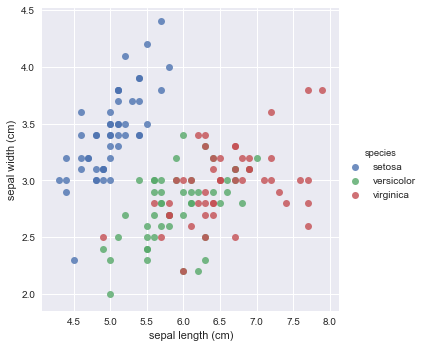

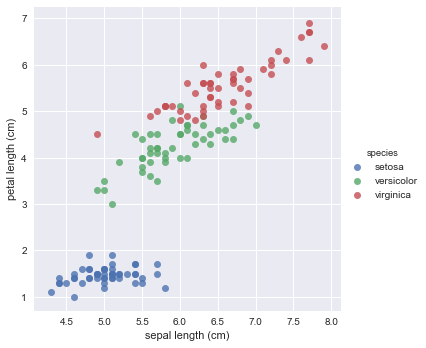

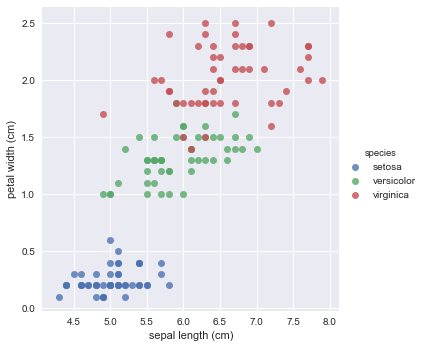

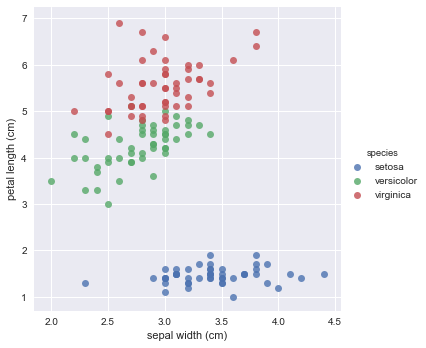

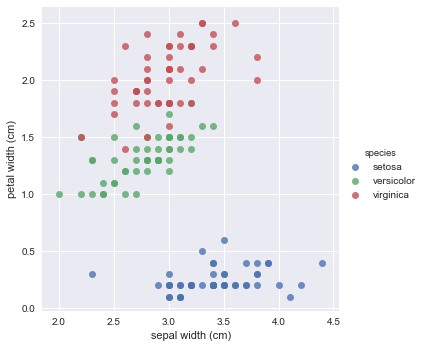

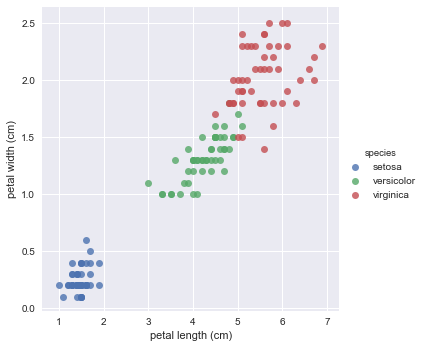

In [4]:
from itertools import combinations

for xy in combinations(iris.feature_names, 2):
    x, y = xy
    sns.lmplot(x, y, 
           data=iris_df, 
           fit_reg=False, 
           hue="species");

We can see, for example, that the petal variables appear to be redundant with respect to one another.

What PCA will do is formulate a set of **orthogonal** varibles, where the number of orthogonal axes is smaller than the number of original variables. It then **projects** the original data onto these axes to obtain transformed variables. 

The key concept is that each set of axes constructed maximizes the amount of residual variability explained. 

We can then fit models to the subset of orthogonal variables that accounts for most of the variability.

Let's do a PCA by hand first, before using scikit-learn:

### Standardization

An important first step for many datasets is to **standardize** the original data. Its important for all variables to be on the same scale because the algorithm will be seeking to maximize variance along each axis. If one variable is numerically larger than another variable, it will tend to have larger variance, and will therefore garner undue attention from the algorithm. 

This dataset is approximately on the same scale, though there are differences, particularly in the fourth variable (petal width):

In [5]:
iris.data[:5]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

Let's apply a standardization transformation from scikit-learn:

In [6]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(iris.data)
X_std[:5]

array([[-0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [-1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [-1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [-1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [-1.02184904,  1.26346019, -1.3412724 , -1.31297673]])

### Eigendecomposition

The PCA algorithm is driven by the eigenvalues and eigenvectors of the original dataset. 

- The eigenvectors determine the direction of each component
- The eigenvalues determine the length (magnitude) of the component

The eigendecomposition is performed on the covariance matrix of the data, which we can derive here using NumPy.

In [7]:
Σ = np.cov(X_std.T)

In [8]:
evals, evecs = np.linalg.eig(Σ)

In [9]:
evals

array([ 2.93035378,  0.92740362,  0.14834223,  0.02074601])

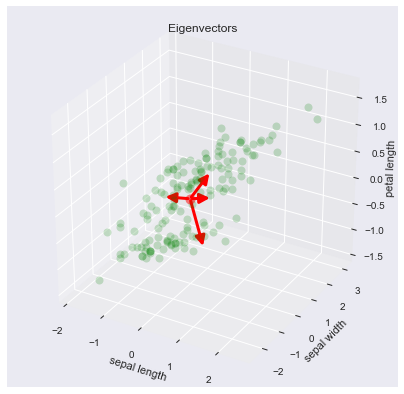

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

variables = [name[:name.find(' (')]for name in iris.feature_names]

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_std[:,0], X_std[:,1], X_std[:,2], 'o', markersize=8, 
        color='green', 
        alpha=0.2)

mean_x, mean_y, mean_z = X_std.mean(0)[:-1]
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in evecs:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])

plt.title('Eigenvectors')


## Selecting components

The eigenvectors are the principle components, which are normalized linear combinations of the original features. They are ordered, in terms of the amount of variation in the dataset that they account for.

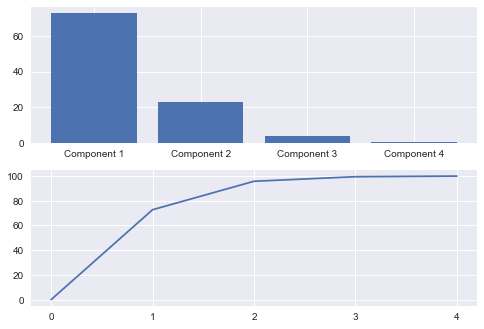

In [13]:
fig, axes = plt.subplots(2, 1)

total = evals.sum()
variance_explained = 100* np.sort(evals)[::-1]/total

axes[0].bar(range(4), variance_explained)
axes[0].set_xticks(range(4));
axes[0].set_xticklabels(['Component ' + str(i+1) for i in range(4)])

axes[1].plot(range(5), np.r_[0, variance_explained.cumsum()])
axes[1].set_xticks(range(5));


## Projecting the data

The next step is to **project** the original data onto the orthogonal axes.

Let's extract the first two eigenvectors and use them as the projection matrix for the original (standardized) variables.

In [14]:
W = evecs[:, :2]
Y = X_std @ W

In [15]:
df_proj = pd.DataFrame(np.hstack((Y, iris.target.astype(int).reshape(-1, 1))),
                      columns=['Component 1', 'Component 2', 'Species'])

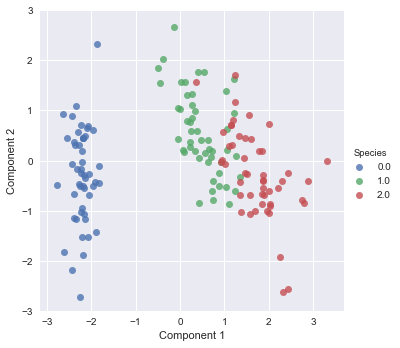

In [16]:
sns.lmplot('Component 1', 'Component 2',
          data=df_proj,
          fit_reg=False,
          hue='Species')

## PCA in `scikit-learn`

`scikit-learn` provides a PCA transformation in its `decomposition` module. 

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, whiten=True).fit(iris.data)
X_pca = pca.transform(iris.data)

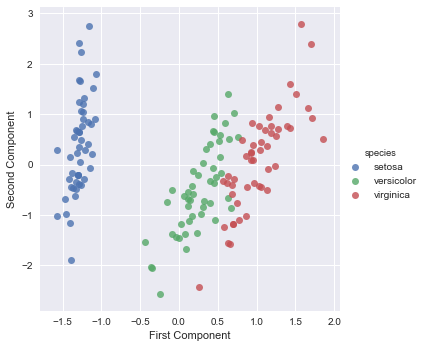

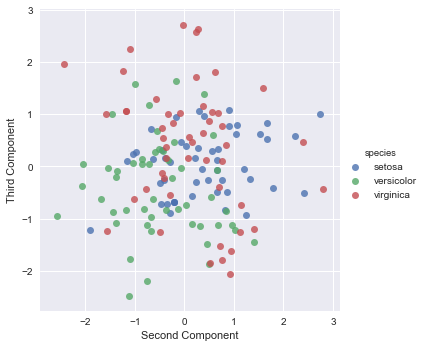

In [18]:
iris_df['First Component'] = X_pca[:, 0]
iris_df['Second Component'] = X_pca[:, 1]
iris_df['Third Component'] = X_pca[:, 2]

sns.lmplot('First Component', 'Second Component', 
           data=iris_df, 
           fit_reg=False, 
           hue="species");

sns.lmplot('Second Component', 'Third Component',
           data=iris_df, 
           fit_reg=False, 
           hue="species");

## Exercise

Import the wine dataset and perform PCA on the predictor variables, and decide how many principal components would you select.

In [19]:
wine = pd.read_table('../data/wine.dat', sep='\s+')
wine.head()

,region,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,1,1.51,-0.56,0.23,-1.17,1.91,0.81,1.03,-0.66,1.22,0.25,0.36,1.84,1.01
1,1,0.25,-0.50,-0.83,-2.48,0.02,0.57,0.73,-0.82,-0.54,-0.29,0.40,1.11,0.96
2,1,0.20,0.02,1.11,-0.27,0.09,0.81,1.21,-0.50,2.13,0.27,0.32,0.79,1.39
3,1,1.69,-0.35,0.49,-0.81,0.93,2.48,1.46,-0.98,1.03,1.18,-0.43,1.18,2.33
4,1,0.29,0.23,1.84,0.45,1.28,0.81,0.66,0.23,0.40,-0.32,0.36,0.45,-0.04


In [20]:
# Write your answer here